#### This work was developed as part of a Kaggle competition 
#### In this notebook I will train a CNN to classify handwritten digits. I will first train a Random Forest, 
#### then move on to training a simple fully connected neural net and finally I will work on some CNN alternatives.
#### I will be using Tensorflow backed Keras in doing this.

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import time
import itertools

np.random.seed(42)
random_seed=42

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



In [69]:
#2 Explore the data

In [81]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [82]:
Y_train, X_train = train["label"], train
X_test = test
del X_train["label"]

Nulls in training set: 0
Nulls in labels: 0
Classes are balanced.


<BarContainer object of 10 artists>

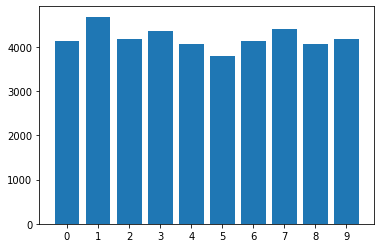

In [83]:
check_nulls_train = X_train.isna().sum()
print("Nulls in training set: " + str(len(check_nulls[check_nulls!= 0])))

check_nulls_train = Y_train.isna().sum()
print("Nulls in labels: " + str(len(check_nulls[check_nulls!= 0])))

print("Classes are balanced.")
plt.bar(Y_train.value_counts().index, Y_train.value_counts(), tick_label=Y_train.value_counts().index)

In [84]:
# Normalising the data for quicker convergence
X_train = X_train/255
X_test = X_test/255

# One hot encoding on labels
Y_train = to_categorical(Y_train, num_classes = 10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

In [99]:
# Let's first fit a simple random forest to obtain a benchmark. Not changing any hyperparams on this one.
start = int(time.time())
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_val)
rf_accuracy = 100*round(accuracy_score(Y_val, Y_pred), 4)
end = int(time.time())
print("Accuracy with a Random Forest model: {}{}".format(rf_accuracy,"%"))
print("Total time for training: {}{}".format(end-start, "seconds"))

Accuracy with a Random Forest model: 88.79%
Total time for training: 26seconds


In [111]:
# So we got ~89% easily with a simple Random Forest. Let's see what a simple Fully Connected Layer will get us.
def baseline_model(num_features=784, num_classes=10, num_layers=[32,32], activation="relu"):
    # create model
    model = Sequential()
    model.add(Dense(num_layers[0], input_dim=num_features, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(num_layers[1], input_dim=num_features, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = baseline_model(num_layers=[32,32])
model.fit(X_train, Y_train, epochs=100, batch_size=100)
_, accuracy = model.evaluate(X_val, Y_val)

Epoch 1/100
378/378 [==============================] - 0s 816us/step - loss: 0.6656 - accuracy: 0.8007
Epoch 2/100
378/378 [==============================] - 0s 795us/step - loss: 0.2785 - accuracy: 0.9169
Epoch 3/100
378/378 [==============================] - 0s 754us/step - loss: 0.2236 - accuracy: 0.9323
Epoch 4/100
378/378 [==============================] - 0s 748us/step - loss: 0.1951 - accuracy: 0.9404
Epoch 5/100
378/378 [==============================] - 0s 734us/step - loss: 0.1742 - accuracy: 0.9472
Epoch 6/100
378/378 [==============================] - 0s 739us/step - loss: 0.1603 - accuracy: 0.9506
Epoch 7/100
378/378 [==============================] - 0s 732us/step - loss: 0.1490 - accuracy: 0.9537
Epoch 8/100
378/378 [==============================] - 0s 743us/step - loss: 0.1375 - accuracy: 0.9571
Epoch 9/100
378/378 [==============================] - 0s 729us/step - loss: 0.1300 - accuracy: 0.9590
Epoch 10/100
378/378 [==============================] - 0s 771us/step - l

378/378 [==============================] - 0s 748us/step - loss: 0.0417 - accuracy: 0.9864
Epoch 80/100
378/378 [==============================] - 0s 867us/step - loss: 0.0398 - accuracy: 0.9869
Epoch 81/100
378/378 [==============================] - 0s 744us/step - loss: 0.0424 - accuracy: 0.9859
Epoch 82/100
378/378 [==============================] - 0s 761us/step - loss: 0.0402 - accuracy: 0.9865
Epoch 83/100
378/378 [==============================] - 0s 799us/step - loss: 0.0404 - accuracy: 0.9864
Epoch 84/100
378/378 [==============================] - 0s 754us/step - loss: 0.0412 - accuracy: 0.9854
Epoch 85/100
378/378 [==============================] - 0s 773us/step - loss: 0.0398 - accuracy: 0.9860
Epoch 86/100
378/378 [==============================] - 0s 799us/step - loss: 0.0415 - accuracy: 0.9863
Epoch 87/100
378/378 [==============================] - 0s 767us/step - loss: 0.0389 - accuracy: 0.9875
Epoch 88/100
378/378 [==============================] - 0s 781us/step - loss:

In [112]:
# I could keep playing with the hyperparams here but with some very light tuning, we got a ~96.7% accuracy

In [141]:
# So let's start playing with some CNNs
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [136]:
def cnn_model(num_classes=10):
    # create model
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (7,7),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 16, kernel_size = (7,7),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = cnn_model()
model.fit(X_train, Y_train, epochs=30, batch_size=200)
_, accuracy = model.evaluate(X_val, Y_val)

Epoch 1/30
189/189 [==============================] - 54s 284ms/step - loss: 0.3882 - accuracy: 0.8733
Epoch 2/30
189/189 [==============================] - 79s 420ms/step - loss: 0.0926 - accuracy: 0.9718
Epoch 3/30
189/189 [==============================] - 69s 363ms/step - loss: 0.0629 - accuracy: 0.9807
Epoch 4/30
189/189 [==============================] - 65s 343ms/step - loss: 0.0533 - accuracy: 0.9833
Epoch 5/30
189/189 [==============================] - 64s 336ms/step - loss: 0.0456 - accuracy: 0.9853
Epoch 6/30
189/189 [==============================] - 66s 348ms/step - loss: 0.0383 - accuracy: 0.9878
Epoch 7/30
189/189 [==============================] - 70s 371ms/step - loss: 0.0341 - accuracy: 0.9889
Epoch 8/30
189/189 [==============================] - 64s 337ms/step - loss: 0.0276 - accuracy: 0.9912
Epoch 9/30
189/189 [==============================] - 67s 353ms/step - loss: 0.0253 - accuracy: 0.9921
Epoch 10/30
189/189 [==============================] - 69s 365ms/step - l

In [123]:
print("Accuracy with a CNN model: {}{}".format(99.3,"%"))
print("Total time for training: {}{}".format(30*55/60, " minutes"))

Accuracy with a CNN model: 99.3%
Total time for training: 27.5 minutes


In [127]:
# Fairly simple CNN got us 99.3%. Worth trying to add some data augmentation

# initialize the number of epochs and batch size
EPOCHS = 30
BS = 200
STEPS_PER_EPOCH = len(X_train)/BS
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
# train the network
H = model.fit_generator(aug.flow(X_train, Y_train, batch_size=BS),
    validation_data=(X_val, Y_val), steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
189/189 [==============================] - 54s 287ms/step - loss: 0.3225 - accuracy: 0.9086 - val_loss: 0.0387 - val_accuracy: 0.9895
Epoch 2/30
189/189 [==============================] - 74s 392ms/step - loss: 0.1327 - accuracy: 0.9608 - val_loss: 0.0344 - val_accuracy: 0.9902
Epoch 3/30
189/189 [==============================] - 72s 381ms/step - loss: 0.1078 - accuracy: 0.9685 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 4/30
189/189 [==============================] - 72s 383ms/step - loss: 0.0903 - accuracy: 0.9720 - val_loss: 0.0336 - val_accuracy: 0.9898
Epoch 5/30
189/189 [==============================] - 64s 338ms/step - loss: 0.0827 - accuracy: 0.9757 - val_loss: 0.0330 - val_accuracy: 0.9890
Epoch 6/30
189/189 [==============================] - 68s 357ms/step - loss: 0.0763 - accuracy: 0.9784 - val_loss: 0.0379 - val_accuracy: 0.9905
Epoch 7/30
189/189 [==============================] - 

In [129]:
print("Accuracy with a CNN model: {}{}".format(99.2,"%"))
print("Total time for training: {}{}".format(30*63/60, " minutes"))

Accuracy with a CNN model: 99.2%
Total time for training: 31.5 minutes


In [130]:
# Not huge improvement with the addition of Data Aug. Let's check out the confusion matrix

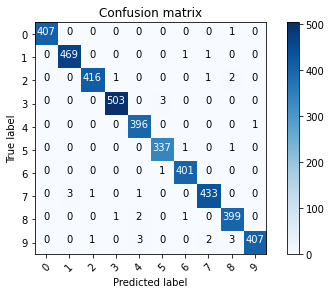

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [133]:
# Some 3s getting confused for 5s, some 7s for 1s, some 9s for 8s. Really low numbers and potentially expected errors.

In [135]:
# Ack - some code was borrowed by Yassine Ghouzam, PhD. Thanks Yassine. Go checkout his implmentation at:
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [144]:
Y_submission = model.predict(X_test)

In [149]:
Y_submission = np.argmax(Y_submission,axis = 1)
Y_submission = pd.Series(Y_submission,name="Label")

In [150]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),Y_submission],axis = 1)
submission.to_csv("kaggle_comp_mnist.csv",index=False)

In [151]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
